In [6]:
from collections import defaultdict
import math
import numpy as np
from numpy import ma
import datetime, time
from datetime import datetime
import netCDF4
from netCDF4 import Dataset, num2date
from scipy.interpolate import griddata
from scipy.spatial import Delaunay


import halem.Base_functions as halem
import halem.Mesh_maker as Mesh_maker
import halem.Functions as Functions
import halem.Calc_path as Calc_path

import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

import os
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
class flow_potentiaalveld():
    def __init__(self, name):
        d = datetime.strptime("23/03/2019 00:00:00", "%d/%m/%Y %H:%M:%S")
        t0 = d.timestamp() 
        x = np.arange(0,1,0.1)
        y = np.arange(0,1,0.1)
        t = np.arange(t0, (t0+2*30*60*30),30*60)

        y, x = np.meshgrid(y, x)
        y = y.reshape(y.size)
        x = x.reshape(y.size)

        nodes = np.zeros((len(x),2))
        nodes[:,0] = y
        nodes[:,1] = x
        
        u = []
        v = []
        for node in nodes:
            ut = 0*t + 2 * np.cos(np.pi*(node[0]))
            vt = 0*t - 2 * np.cos(np.pi*(node[1]))
            u.append(ut)
            v.append(vt)
        
        self.v = np.transpose(np.array(v))
        self.u = np.transpose(np.array(u))
        self.WD = np.random.rand(self.u.shape[0],self.u.shape[1])*12 + 8
        #self.WD = self.u * 0 + 20
        self.t = t
        self.nodes = nodes
        self.tria = Delaunay(nodes)
        
def compute_cost(week_rate, fuel_rate):
    second_rate = week_rate/7/24/60/60
    return lambda travel_time, speed: (travel_time*second_rate + fuel_rate*travel_time * speed**3)

def compute_co2(fuel_rate):
    return lambda travel_time, speed: (fuel_rate*travel_time * speed**3)

In [3]:
nl = (3,2.5)
dx_min = 0.01
blend = 1
vship = np.array([[5,10]
                 ])
WD_min = np.array([8,7])
WPVI = np.array([4000, 10000])
ukc = 1.5
WWL = 40
name_textfile_flow = 'maaktnietuit'
Load_flow = flow_potentiaalveld
number_of_neighbor_layers = 2

Q_cost = compute_cost(700_000, 0.008)
Q_co2 = compute_co2(1)

# Pre-Processign

In [4]:
start_time = time.time()

Roadmap_t = Mesh_maker.Graph_flow_model(name_textfile_flow, 
                                        dx_min, 
                                        blend, 
                                        nl, 
                                        number_of_neighbor_layers, 
                                        vship, 
                                        Load_flow, 
                                        WD_min,
                                        WPVI,
                                        WWL = WWL,
                                        ukc = ukc,
                                        compute_cost = Q_cost,
                                        compute_co2 = Q_co2,
                                       )

#TomTom.save_object(Roadmap, name_textfile_save)

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

4/4
the computational time is: 12.08 sec


# Route optimization

In [7]:
t0 = "23/03/2019 03:00:00"          #Departure time

start = (0.2, 0.2)
stop = (0.8, 0.8)
v_max = 7

start_time = time.time()

path_t, time_t, dist_t = halem.HALEM_time(start, stop, t0, v_max, Roadmap_t)
path_s, time_s, dist_s = halem.HALEM_space(start, stop, t0, v_max, Roadmap_t)
path_c, time_c, dist_c = halem.HALEM_cost(start, stop, t0, v_max, Roadmap_t)
path_p, time_p, dist_p = halem.HALEM_co2(start, stop, t0, v_max, Roadmap_t)

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

the computational time is: 0.29 sec


# Plot the results

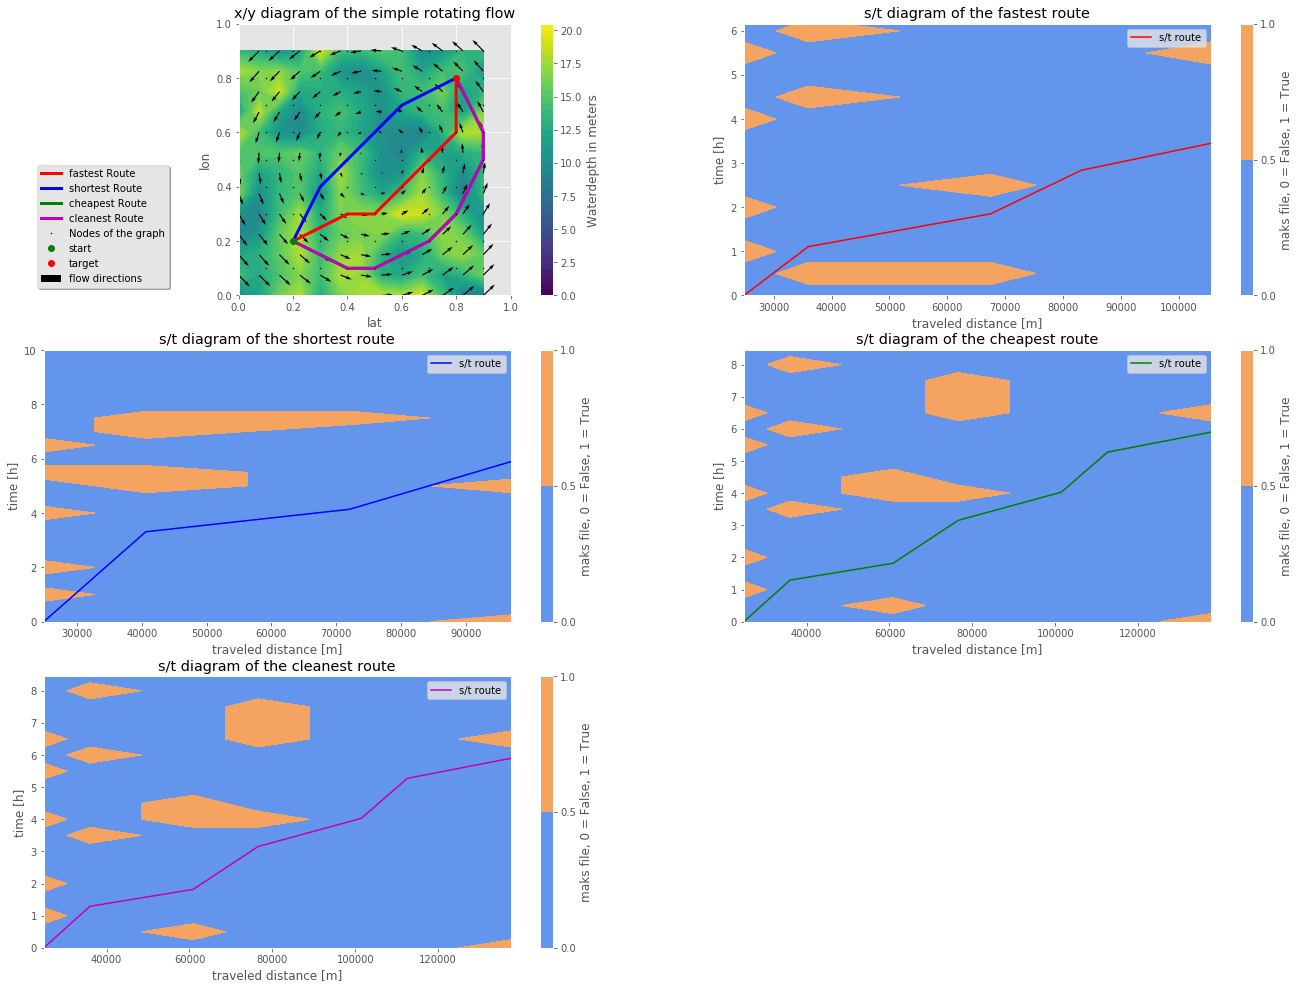

In [8]:
fig = plt.figure(figsize=(23, 17))

ax = plt.subplot(3,2,1)
plt.axis('square')
a = 1

x_r = np.arange(0,1, 0.075)
y_r = np.arange(0,1, 0.075)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = griddata((Roadmap_t.nodes[:,1], Roadmap_t.nodes[:,0]), Roadmap_t.WD[:,0], (x_r, y_r), method= 'linear')
u_r = griddata((Roadmap_t.nodes[:,1], Roadmap_t.nodes[:,0]), Roadmap_t.u[:,0], (x_r, y_r), method= 'linear')
v_r = griddata((Roadmap_t.nodes[:,1], Roadmap_t.nodes[:,0]), Roadmap_t.v[:,0], (x_r, y_r), method= 'linear')

cval = np.arange(0,21,0.5)
im = plt.contourf(x_r,y_r,WD_r, cval)
fig.colorbar(im, ax=ax, label = 'Waterdepth in meters')

plt.quiver(x_r[::a,::a],
           y_r[::a,::a],
           u_r[::a,::a],
           v_r[::a,::a],
           label = 'flow directions'
          )
plt.plot(path_t[:,0], path_t[:,1],'r', label = 'fastest Route', linewidth = 3)
plt.plot(path_s[:,0], path_s[:,1],'b', label = 'shortest Route', linewidth = 3)
plt.plot(path_c[:,0], path_c[:,1],'g', label = 'cheapest Route', linewidth = 3)
plt.plot(path_p[:,0], path_p[:,1],'m', label = 'cleanest Route', linewidth = 3)

plt.plot(Roadmap_t.nodes[:,1], Roadmap_t.nodes[:,0], 'k.', label = 'Nodes of the graph', markersize = 1)
plt.plot(path_t[0, 0], path_t[0, 1], 'go', label = 'start')
plt.plot(path_t[-1, 0 ], path_t[-1, 1], 'ro', label = 'target')


plt.xlim(0,1)
plt.ylim(0,1)
plt.title(r'x/y diagram of the simple rotating flow')
ax.legend(loc='upper center', bbox_to_anchor=(-0.5, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.xlabel('lat')
plt.ylabel('lon')

plt.subplot(3,2,2)
halem.plot_timeseries2(path_t, time_t, Roadmap_t, 'r')
plt.title('s/t diagram of the fastest route')


plt.subplot(3,2,3)
halem.plot_timeseries2(path_s, time_s, Roadmap_t, 'b')
plt.title('s/t diagram of the shortest route')


plt.subplot(3,2,4)
halem.plot_timeseries2(path_c, time_c, Roadmap_t, 'g')
plt.title('s/t diagram of the cheapest route')

plt.subplot(3,2,5)
halem.plot_timeseries2(path_p, time_p, Roadmap_t, 'm')
plt.title('s/t diagram of the cleanest route')

plt.show()

Text(0, 0.5, 'lon')

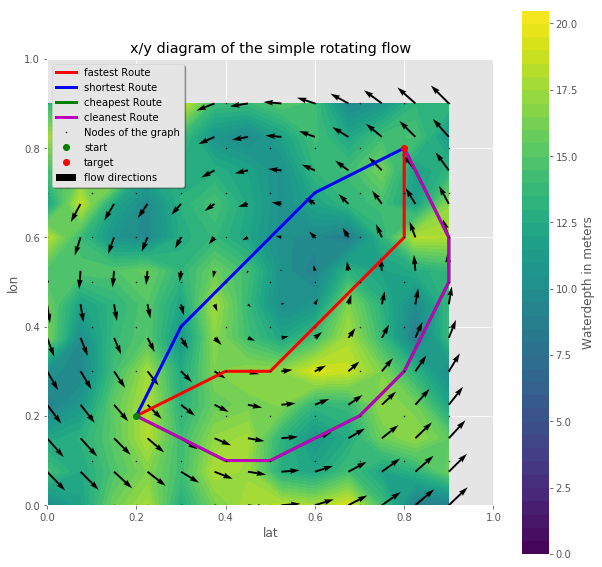

In [9]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(1,1,1)
plt.axis('square')
a = 1

x_r = np.arange(0,1, 0.075)
y_r = np.arange(0,1, 0.075)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = griddata((Roadmap_t.nodes[:,1], Roadmap_t.nodes[:,0]), Roadmap_t.WD[:,0], (x_r, y_r), method= 'linear')
u_r = griddata((Roadmap_t.nodes[:,1], Roadmap_t.nodes[:,0]), Roadmap_t.u[:,0], (x_r, y_r), method= 'linear')
v_r = griddata((Roadmap_t.nodes[:,1], Roadmap_t.nodes[:,0]), Roadmap_t.v[:,0], (x_r, y_r), method= 'linear')

cval = np.arange(0,21,0.5)
im = plt.contourf(x_r,y_r,WD_r, cval)
fig.colorbar(im, ax=ax, label = 'Waterdepth in meters')

plt.quiver(x_r[::a,::a],
           y_r[::a,::a],
           u_r[::a,::a],
           v_r[::a,::a],
           label = 'flow directions'
          )
plt.plot(path_t[:,0], path_t[:,1],'r', label = 'fastest Route', linewidth = 3)
plt.plot(path_s[:,0], path_s[:,1],'b', label = 'shortest Route', linewidth = 3)
plt.plot(path_c[:,0], path_c[:,1],'g', label = 'cheapest Route', linewidth = 3)
plt.plot(path_p[:,0], path_p[:,1],'m', label = 'cleanest Route', linewidth = 3)

plt.plot(Roadmap_t.nodes[:,1], Roadmap_t.nodes[:,0], 'k.', label = 'Nodes of the graph', markersize = 1)
plt.plot(path_t[0, 0], path_t[0, 1], 'go', label = 'start')
plt.plot(path_t[-1, 0 ], path_t[-1, 1], 'ro', label = 'target')


plt.xlim(0,1)
plt.ylim(0,1)
plt.title(r'x/y diagram of the simple rotating flow')
ax.legend(loc='best', ncol=1, fancybox=True, shadow=True)
plt.xlabel('lat')
plt.ylabel('lon')